In [1]:
import pandas as pd
import os #데이터불러오기용
import numpy as np
import cv2
import matplotlib.pyplot as plt

#경고무시
import warnings 
warnings.filterwarnings("ignore")


import tensorflow_addons as tfa #애드온 
import tensorflow as tf
from tensorflow.keras.utils import to_categorical #원핫인코딩용
from tensorflow.keras.preprocessing import image #이미지 전처리
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ReduceLROnPlateau # 콜백함수

# 전이학습 
from tensorflow.keras.applications import VGG16 # VGG16 모델 
from keras.applications.vgg16 import preprocess_input

# 데이터 불러오기

In [2]:
main_folder = "../input/even-more-fruitssssss/results/train" # 경로를 바인딩
class_names=os.listdir(main_folder) #경로를 listdir 한 값을 class_names에 바인딩 (라벨로 쓸 것)
print(class_names)
print("\n")

validation_folder = "../input/even-more-fruitssssss/results/val"
val_class_names=os.listdir(validation_folder)
print(val_class_names)
print("\n")

test_folder = "../input/even-more-fruitssssss/results/test"
test_class_names = os.listdir(validation_folder)
print(test_class_names)


['Orange', 'Pineapple', 'Apple', 'Papaya', 'Dragon Fruit', 'Banana', 'Cherry', 'Mango']


['Orange', 'Pineapple', 'Apple', 'Papaya', 'Dragon Fruit', 'Banana', 'Cherry', 'Mango']


['Orange', 'Pineapple', 'Apple', 'Papaya', 'Dragon Fruit', 'Banana', 'Cherry', 'Mango']


In [3]:
x=[] # value 가 들어감
y=[] # label이 들어감 
#train test split 하려고 x y로 뒀습니다 

for folder in os.listdir(main_folder):
    image_list=os.listdir(main_folder+"/"+folder)
    # ../input/even-more-fruitssssss/results/train + / + label폴더('Orange' 등..) 이 되겠죠?
    for img_name in image_list: # 한번더 바인딩하면서 이젠 label 폴더 안에 이미지 파일 하나하나를 불러옴
        
        img=image.load_img(main_folder+"/"+folder+"/"+img_name,target_size=(224,224))
        # /kaggle/input/even-more-fruitssssss/results/train/Apple/Image_101.jpg 이런식의 경로가 될겁니다.
        # load_img 하면서 사이즈를 224,224로 설정
        img=image.img_to_array(img) 
        
       
        img=preprocess_input(img) # 이미지 전처리 BGR -> RGB로 바꿔주고 , 정규화(-1에서 1사이 값) 해줌
        
        x.append(img) # 이미지
        y.append(class_names.index(folder)) # 라벨

        
        
        

In [28]:
folder

'Mango'

In [27]:
img_name

'Image_193.jpg'

0


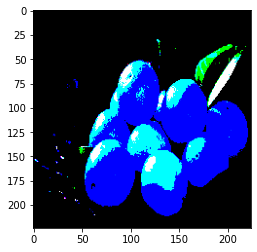

In [4]:
plt.imshow(x[0])
print(y[0])

In [5]:
val_images=[]
val_images_Original=[]
val_image_label=[]

for folder in os.listdir(validation_folder):
    image_list=os.listdir(validation_folder+"/"+folder)
    for img_name in image_list:
     
        img=image.load_img(validation_folder+"/"+folder+"/"+img_name,target_size=(224,224))
        
    
        img=image.img_to_array(img)
        
     #혹시 몰라서 카피 
        val_images_Original.append(img.copy())
        img=preprocess_input(img) 
        
       
        val_images.append(img)
        val_image_label.append(val_class_names.index(folder))
        
        

0


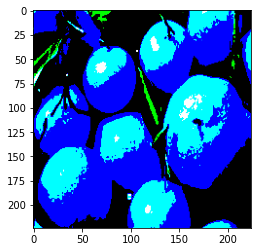

In [6]:
plt.imshow(val_images[0])
print(val_image_label[0])

In [7]:
test_images=[]
test_images_Original=[]
test_image_label=[]

for folder in os.listdir(test_folder):
    image_list=os.listdir(test_folder+"/"+folder)
    for img_name in image_list:
       
        img=image.load_img(test_folder+"/"+folder+"/"+img_name,target_size=(224,224))
        
       
        img=image.img_to_array(img)
        
       
        test_images_Original.append(img.copy())
        img=preprocess_input(img) 
        
       
        test_images.append(img)
        test_image_label.append(test_class_names.index(folder))
        

AxesImage(54,36;334.8x217.44) 0


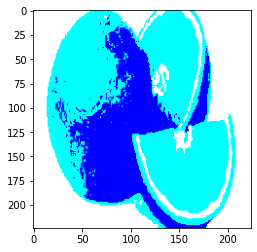

In [8]:
print(plt.imshow(test_images[0]),test_image_label[0])


In [9]:

print("Training Dataset")

x=np.array(x) 
print(x.shape)

y=to_categorical(y) # to_categorical 하면 원핫인코딩이 됩니다. (하기전엔 망고 1 사과 2 용과 3 이런식이였음)


print(y.shape)


print("Validation Dataset")

val_images=np.array(val_images) 
print(val_images.shape)

val_image_label=to_categorical(val_image_label) 
print(val_image_label.shape)

print("Test Dataset")

test_images=np.array(test_images) 
print(test_images.shape)

test_image_label=to_categorical(test_image_label) 
print(test_image_label.shape)

Training Dataset
(698, 224, 224, 3)
(698, 8)
Validation Dataset
(83, 224, 224, 3)
(83, 8)
Test Dataset
(95, 224, 224, 3)
(95, 8)


In [33]:
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [10]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.15)

In [11]:
# 정확도가 99 이상이면 훈련을 멈추는 콜백함수 정의
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\n stop training.")
            self.model.stop_training = True
            
my_callback = MyCallback()
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

# 콜백함수 파라미터 참조 https://keras.io/ko/callbacks/
# ReduceLROnPlateau -> https://deep-deep-deep.tistory.com/56

In [12]:
model_vgg16=VGG16(weights='imagenet') #전이학습 가중치 imagenet
input_layer=layers.Input(shape=(224,224,3)) # 입력층 224,224,3 위에서 224,224로 지정했고 컬러이므로 3차원
model_vgg16=VGG16(weights='imagenet',input_tensor=input_layer,include_top=False)
last_layer=model_vgg16.output
flatten=layers.Flatten()(last_layer)  #평탄화
output_layer=layers.Dense(8,activation='softmax')(flatten) #num_classes = 8 8개로 분류할거라 아웃풋 8
model_vgg16=models.Model(inputs=input_layer,outputs=output_layer)


for layer in model_vgg16.layers[:-1]:
    layer.trainable=False    # 가중치 동결  
    
    
# 전이학습을 하기 위해 사전학습된 모델을 가져와 층을 더 추가하려면 include_top=False로 해주어야 한다.
# 모델 동결 https://velog.io/@pppanghyun/%EC%A0%84%EC%9D%B4%ED%95%99%EC%8A%B5-%EB%AA%A8%EB%8D%B8-%EB%8F%99%EA%B2%B0-Model-Freezing

2023-01-24 04:34:32.057459: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 04:34:32.058385: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 04:34:32.169245: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 04:34:32.170190: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 04:34:32.171041: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

58900480/58889256 [==============================] - 0s 0us/step


In [13]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=8)]

CALLBACKS = [my_callback, rop_callback]
    
model_vgg16.compile(optimizer='adam',
                              loss=tf.losses.CategoricalCrossentropy(), #다중분류를 위해
                              metrics=METRICS)
model_vgg16.summary()

# 손실함수 종류 https://cheris8.github.io/artificial%20intelligence/DL-Keras-Loss-Function/

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

* 인풋레이어 (224,224,3) -> 컨볼루션 2 (224,224,64) -> 맥스풀링 (112,112,64) -> 컨볼루션 2 (112,112,128) -> 
* 맥스풀링 (56,56,128) -> 컨볼루션 3 (56,56,256) -> 맥스풀링 (28,28,256) -> 컨볼루션 3 (28,28,512) -> 맥스풀링 (14,14,512)  
* -> 컨볼루션 3 (14,14,512 변동없음) -> 맥스풀링 (7,7,512) -> 평탄화 (7*7*512 = 25088) -> 
* dense (num_classes 가 8이므로 8)

In [14]:
EPOCHS = 100
history_vgg = model_vgg16.fit(xtrain,ytrain,batch_size=16,verbose=True,validation_data=(xtest,ytest), callbacks=CALLBACKS, epochs=EPOCHS)

2023-01-24 04:34:40.752204: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2023-01-24 04:34:43.219957: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


38/38 [==============================] - 19s 166ms/step - loss: 11.6933 - acc: 0.6965 - auc: 0.8430 - f1_score: 0.6718 - val_loss: 3.8240 - val_acc: 0.8667 - val_auc: 0.9347 - val_f1_score: 0.8563
Epoch 2/100
38/38 [==============================] - 3s 72ms/step - loss: 0.8820 - acc: 0.9696 - auc: 0.9847 - f1_score: 0.9669 - val_loss: 3.2404 - val_acc: 0.8952 - val_auc: 0.9509 - val_f1_score: 0.8854
Epoch 3/100
38/38 [==============================] - 3s 72ms/step - loss: 0.0308 - acc: 0.9933 - auc: 0.9981 - f1_score: 0.9923 - val_loss: 5.8747 - val_acc: 0.8571 - val_auc: 0.9236 - val_f1_score: 0.8317

 stop training.


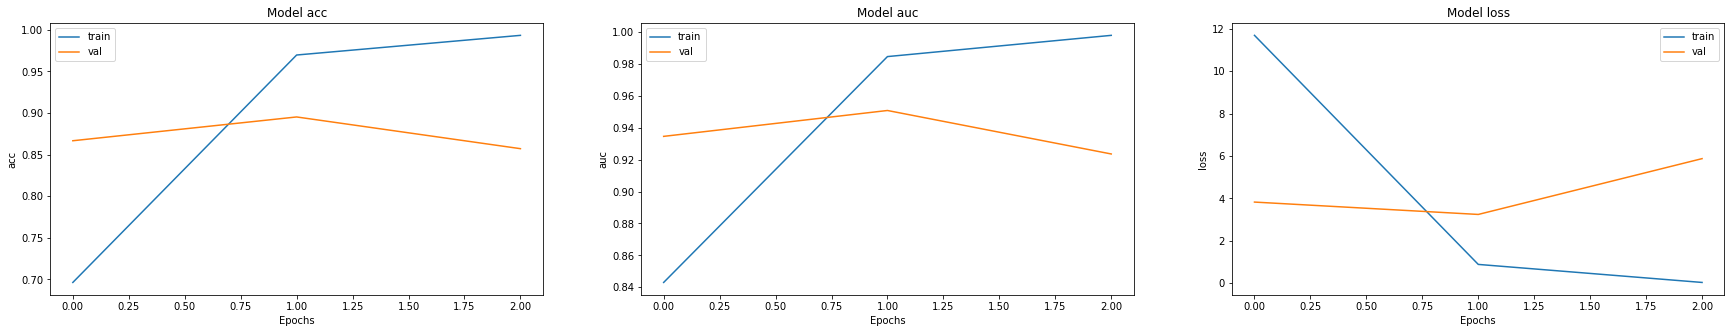

In [15]:
fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel() #1차원 변환 ravel

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history_vgg.history[metric])
    ax[i].plot(history_vgg.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])
    
    
    # 1에포크에서 기하급수적으로 acc auc가 올라가고 loss가 줄었다.
    # 그 이후엔 성능 향상이 더디고 acc 99이상이면 멈추기로 정의 했으므로 epoch3에서 멈춘 모습이다.
    

In [16]:
model_vgg16.save("vgg16_model.hdf5") #모델 저장 

In [17]:
# predict('/kaggle/input/even-more-fruitssssss/results/train/Apple/Image_100.jpg',model_vgg16) 하면 
# 이미지가 나오고 그 이미지가 뭔지 예측하는 함수를 만들 겁니다.

def predict(img_name, model):
    img=image.load_img(img_name,target_size=(224,224))
    img=image.img_to_array(img) #시각화 하기위한 array
    plt.imshow(img.astype('int32')) #imshow
    plt.show() 
    img=preprocess_input(img) # 다 보여줬으면 전처리 
    prediction=model.predict(img.reshape(1,224,224,3)) # 예측
    output=np.argmax(prediction) # 가장 높은 값 = 예측값
    print(class_names[output]) 



def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i] #예측값 실제값 이미지
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.astype('int32'))
    predicted_label=np.argmax(predictions_array)
    true_label=np.argmax(true_label)

In [18]:
predictions=[]

for img in test_images:
    img=img.reshape(1,224,224,3)
    predictions.append(model_vgg16.predict(img))

In [19]:
pred_labels = model_vgg16.predict(test_images)

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_image_label, pred_labels, target_names=test_class_names))


# 테스팅 결과 파파야랑 망고는 미흡한 것을 볼 수 있다.

              precision    recall  f1-score   support

      Orange       1.00      1.00      1.00        13
   Pineapple       1.00      0.83      0.91        12
       Apple       1.00      0.85      0.92        13
      Papaya       0.80      0.57      0.67         7
Dragon Fruit       0.80      0.86      0.83        14
      Banana       0.93      1.00      0.96        13
      Cherry       0.86      0.92      0.89        13
       Mango       0.69      0.90      0.78        10

   micro avg       0.88      0.88      0.88        95
   macro avg       0.88      0.87      0.87        95
weighted avg       0.89      0.88      0.88        95
 samples avg       0.88      0.88      0.88        95



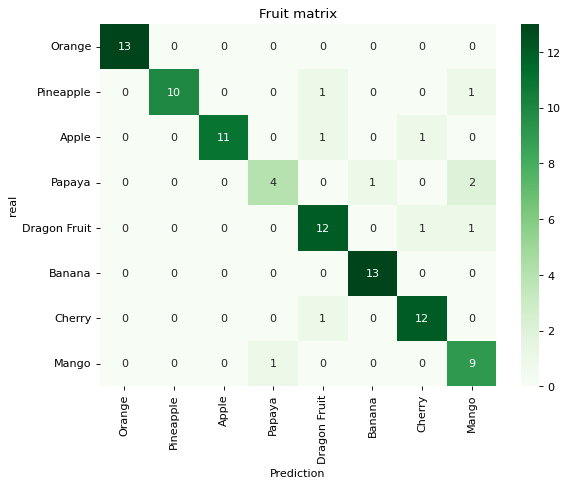

In [21]:
import seaborn as sns
pred_ls = np.argmax(pred_labels, axis=1) # 예측값
test_ls = np.argmax(test_image_label, axis=1) # 진짜값

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= test_class_names,
                yticklabels=test_class_names)

plt.title('Fruit matrix')
plt.xlabel('Prediction')
plt.ylabel('real')
plt.show(ax)


# 망고와 파파야를 잘못 예측한 게 2건이나 된다.

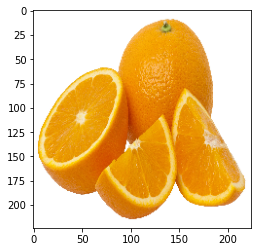

Orange


In [25]:
predict("../input/even-more-fruitssssss/results/test/Orange/Image_77.jpg",model_vgg16)

In [23]:
!pip install gradio -q

In [24]:
import gradio as gr
model = tf.keras.models.load_model("./vgg16_model.hdf5")
def classify_image(inp):
    inp = inp.reshape((-1,224, 224, 3))
    prediction = model.predict(inp)
    return class_names[int(np.argmax(prediction,axis=1))]

gr.Interface(fn=classify_image, 
             inputs=gr.Image(shape=(224, 224)),
             outputs="text").launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://6d0420a0-1f76-4e67.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


# 노란색 사과는 잘못 인식한다.
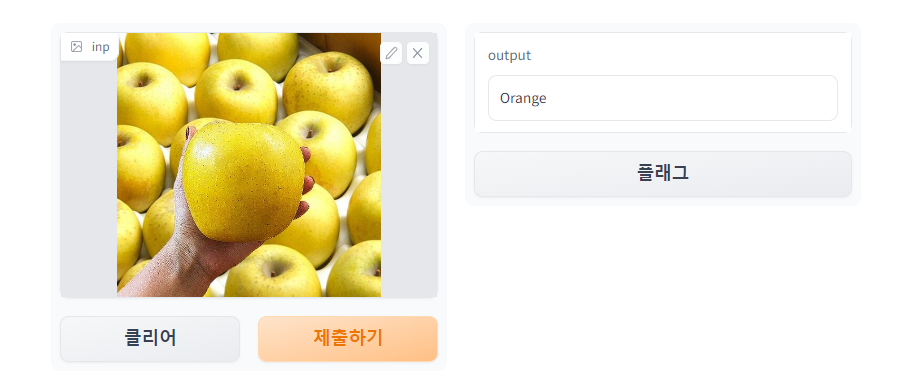

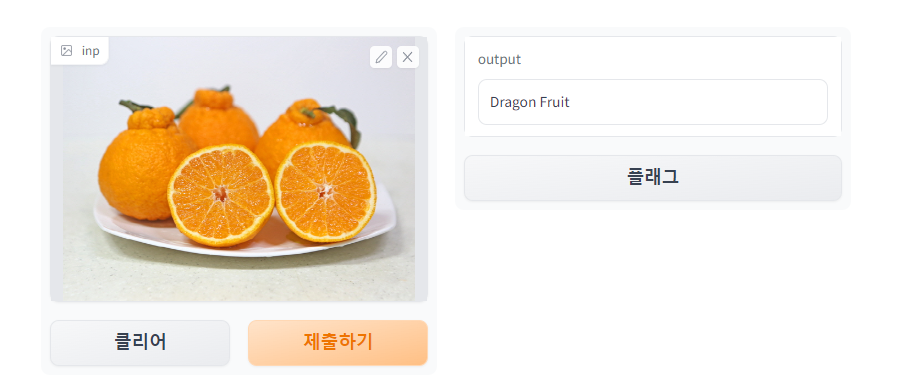
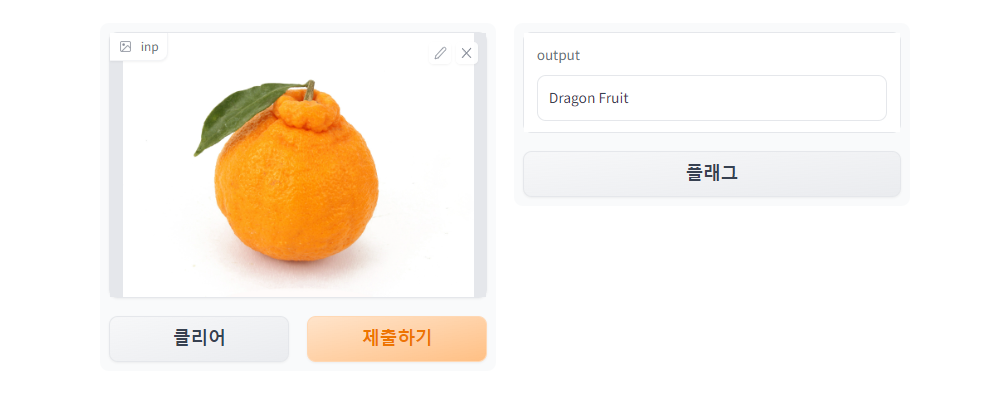
# 한라봉을 용과로 인식한다.
